# Predicting Appointment No Shows  with Amazon SageMaker XGBoost
_**Supervised Learning with Gradient Boosted Trees: A Binary Prediction Problem**_

---

---

## Contents

1. [Background](#Background)
1. [Prepration](#Preparation)
1. [Data](#Data)
    1. [Exploration](#Exploration)
    1. [Transformation](#Transformation)
1. [Training](#Training)
1. [Hosting](#Hosting)
1. [Evaluation](#Evaluation)
1. [Exentsions](#Extensions)

---

## Background


This notebook uses XGBoost to predict whether a patient will be a no-show for a medical appointment.The dataset was downloaded from Kaggle https://www.kaggle.com/joniarroba/noshowappointments. The appointment data of 110,527 records was collected from medical clinics in the city of Vitoria, Brazil, over a three month period in 2016.

The following steps were undertaken:

* Preparing your Amazon SageMaker notebook
* Downloading data from the internet into Amazon SageMaker
* Investigating and transforming the data so that it can be fed to Amazon SageMaker algorithms
* Estimating a model using the Gradient Boosting algorithm
* Evaluating the effectiveness of the model
* Setting the model up to make on-going predictions

---

## Preparation

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

## Notes
The first model uses age and waiting time as continuous features. However, the model performs poorly as the recall is very low.

In [1]:
bucket = 'sagemaker-sf-strategenics'
prefix = 'sagemaker/DEMO-xgboost-noShow'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

Bring in the Python libraries that we'll use throughout the analysis

In [2]:
from datetime import date
from datetime import time
from datetime import datetime
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker                                  # Amazon SageMaker's Python SDK provides many helper functions
from sagemaker.predictor import csv_serializer    # Converts strings for HTTP POST requests on inference
import seaborn as sns

---

## Data


In [16]:
data_key = 'appointmentData.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

noShow= pd.read_csv(data_location)

pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)         # Keep the output on one page

noShow.rename(columns = {'Hipertension': 'Hypertension',
                         'Handcap': 'Disabilities'}, inplace = True)

#convert date columns to a date format
noShow['tempSchedDate'] = pd.to_datetime(noShow['ScheduledDay'])
noShow['tempAppDate'] = pd.to_datetime(noShow['AppointmentDay'])
#get the date part of the date columns, as the Scheduled date has a time component but the appointment day does not
noShow['AppointmentDate']= noShow['tempAppDate'].dt.date
noShow['AppointmentBooked']= noShow['tempSchedDate'].dt.date
#calculate the waiting time
noShow['WaitingTime'] = (noShow.AppointmentDate - noShow.AppointmentBooked).dt.days

#Find the day of the week of the appointment
noShow['DayOfWeek'] = noShow['tempAppDate'].dt.day_name()

#drop the columns no longer needed
noShow = noShow.drop(['ScheduledDay','AppointmentDay','tempSchedDate','tempAppDate'], axis=1)

noShow.PatientId = noShow.PatientId.astype('int64')
noShow.set_index('AppointmentID', inplace = True)

noShow['Age'] = np.where(noShow['Age']<0, np.nan, noShow['Age'])
noShow['WaitingTime'] = np.where(noShow['WaitingTime']<0, np.nan, noShow['WaitingTime'])
noShow['Disability'] = np.where(noShow['Disabilities']>1, 1, noShow['Disabilities'])

#determine if a patient has had a previous appointment
noShow.sort_values(by=['PatientId','AppointmentDate'], inplace=True)
pd.options.display.max_rows=100
noShow['PreviousAppointment'] = noShow.sort_values(by = ['PatientId','AppointmentDate']).groupby(['PatientId']).cumcount()
#print(noShow[['PatientId','AppointmentDate', 'PreviousAppointment']].head(100)) 


a = noShow.groupby(pd.cut(noShow.PreviousAppointment, bins = [-1, 0,1,2,3,4,5, 85], include_lowest = True))[['PreviousAppointment']].count()
b = pd.DataFrame(a)
b.set_index(pd.Series(['0', '1', '2', '3', '4', '5', '> 5']))

noShow['NoShow']=np.where(noShow['No-show'] == "Yes", 1,0)
count = noShow.groupby(['No-show', 'NoShow']).size() 
print(count)

#noShow['PreviousNoShow'] = (noShow[noShow['PreviousAppointment'] > 0].sort_values(['PatientId', 'AppointmentDate']).groupby(['PatientId'])['NoShow'].cumsum())
noShow['NumberOfPreviousNoShow'] = (noShow.sort_values(['PatientId', 'AppointmentDate']).groupby(['PatientId'])['NoShow'].cumsum())
noShow['PreviousNoShows']=noShow['NumberOfPreviousNoShow']-noShow['NoShow']


def history(x):
    if x['PreviousAppointment'] == 0 : return 'First appointment'
    elif x['PreviousAppointment'] > 0 and x['PreviousNoShows'] == 0: return 'No previous no-shows'
    else: return 'At least one previous no-show'
    

noShow['PatientHistory'] = noShow.apply(history,axis=1)

pd.options.display.max_rows=100
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 500)
noShow.sort_values(by=['PatientId','AppointmentDate'], inplace=True)
#print(noShow[['PatientId','AppointmentDate', 'No-show', 'PreviousAppointment','PreviousNoShows','PatientHistory']].head(100)) 

 
count = noShow.groupby(['PatientHistory']).size() 
print(count)

noShow['No-show'] = noShow['No-show'].astype('category')

noShowFinal = noShow[['No-show', 'Gender', 'Age','Scholarship','Hypertension','Diabetes','Alcoholism','Disability','SMS_received','WaitingTime','DayOfWeek','PatientHistory']].copy()
noShowFinal.info()
#create indicator columns for categorical columns, as requried by XGBoost
model_data = pd.get_dummies(noShowFinal) 
model_data.head()

train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=8147), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])   # Randomly sort the data then split out first 70%, second 20%, and last 10%

print(train_data.shape)
print(validation_data.shape)
print(test_data.shape)


pd.concat([train_data['No-show_Yes'], train_data.drop(['No-show_No', 'No-show_Yes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([validation_data['No-show_Yes'], validation_data.drop(['No-show_No', 'No-show_Yes'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')


No-show  NoShow
No       0         88208
Yes      1         22319
dtype: int64
PatientHistory
At least one previous no-show    15624
First appointment                62299
No previous no-shows             32604
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 110527 entries, 5751990 to 5660958
Data columns (total 12 columns):
No-show           110527 non-null category
Gender            110527 non-null object
Age               110526 non-null float64
Scholarship       110527 non-null int64
Hypertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Disability        110527 non-null int64
SMS_received      110527 non-null int64
WaitingTime       110522 non-null float64
DayOfWeek         110527 non-null object
PatientHistory    110527 non-null object
dtypes: category(1), float64(2), int64(6), object(3)
memory usage: 10.2+ MB
(77368, 21)
(22106, 21)
(11053, 21)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 77368 


# Data Summary

* There are 110,527 patient records, and 13 features for each patient
* The features are mixed; some numeric, some categorical


*Features:*
* `Age`: Patient's age. Integer -1 to 115
* `Gender`: Patient's gender, string M,F
* `Alcoholism`: Binary, 1=yes
* `Diabetes`:Binary, 1= yes
* `Hypertension`:Binary, 1= yes
* `Disabilities`: The number of disabilities for a patient. Integer, 1-4
* `Scholarship`: This indicates whether the patient receives financial support from the government. Binary, 1=yes
* `Neighbourhood`: This is the location of the medical clinic. String, 80 values
* `SMS_receceived`:Whether they received a SMS reminder before the appointment. Binary, 1= yes
* `AppointmentBooked`: Date that the appointment was booked
* `AppointmentDate`: Date of the appointment
* `DayOfWeek`: The weekday of the appointment. Integer, 0-5
* `WaitingTime`: The number of days between booking the appointment and the appointment date. Integer, -6 to 179


*Target variable:*
* `No-show`: Was the patient a no-show? Binary: 1=yes,0=no
Overall, 20% of the patients were no-shows.

---

## Training
Now we know that most of our features have skewed distributions, some are highly correlated with one another, and some appear to have non-linear relationships with our target variable.  Also, for targeting future prospects, good predictive accuracy is preferred to being able to explain why that prospect was targeted.  Taken together, these aspects make gradient boosted trees a good candidate algorithm.

There are several intricacies to understanding the algorithm, but at a high level, gradient boosted trees works by combining predictions from many simple models, each of which tries to address the weaknesses of the previous models.  By doing this the collection of simple models can actually outperform large, complex models.  Other Amazon SageMaker notebooks elaborate on gradient boosting trees further and how they differ from similar algorithms.

`xgboost` is an extremely popular, open-source package for gradient boosted trees.  It is computationally powerful, fully featured, and has been successfully used in many machine learning competitions.  Let's start with a simple `xgboost` model, trained using Amazon SageMaker's managed, distributed training framework.

First we'll need to specify the ECR container location for Amazon SageMaker's implementation of XGBoost.

In [3]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost', repo_version='0.90-1')

Then, because we're training with the CSV file format, we'll create `s3_input`s that our training function can use as a pointer to the files in S3, which also specify that the content type is CSV.

In [4]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

First we'll need to specify training parameters to the estimator.  This includes:
1. The `xgboost` algorithm container
1. The IAM role to use
1. Training instance type and count
1. S3 location for output data
1. Algorithm hyperparameters

And then a `.fit()` function which specifies:
1. S3 location for output data.  In this case we have both a training and validation set which are passed in.

In [8]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(eval_metric='auc',
                        objective='binary:logistic',
                        num_round=100,
                        rate_drop=0.3,
                        tweedie_variance_power=1.4)

hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                        'min_child_weight': ContinuousParameter(1, 10),
                        'alpha': ContinuousParameter(0, 2),
                        'max_depth': IntegerParameter(1, 10)}

objective_metric_name = 'validation:auc'

tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=20,
                            max_parallel_jobs=3)

tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False)



boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'InProgress'

In [ ]:
#!conda install -y -c conda-forge xgboost 

In [10]:
tuner.best_training_job()           

'sagemaker-xgboost-191112-2311-016-348d5e93'

In [ ]:
train_data.info()

---

## Hosting
Now that we've trained the `xgboost` algorithm on our data, let's deploy a model that's hosted behind a real-time endpoint.

In [ ]:
xgb_predictor = tuner.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')



2019-11-12 23:32:15 Starting - Preparing the instances for training
2019-11-12 23:32:15 Downloading - Downloading input data
2019-11-12 23:32:15 Training - Training image download completed. Training in progress.
2019-11-12 23:32:15 Uploading - Uploading generated training model
2019-11-12 23:32:15 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is

---

## Evaluation
There are many ways to compare the performance of a machine learning model, but let's start by simply comparing actual to predicted values.  In this case, we're simply predicting whether the customer subscribed to a term deposit (`1`) or not (`0`), which produces a simple confusion matrix.

First we'll need to determine how we pass data into and receive data from our endpoint.  Our data is currently stored as NumPy arrays in memory of our notebook instance.  To send it in an HTTP POST request, we'll serialize it as a CSV string and then decode the resulting CSV.

*Note: For inference with CSV format, SageMaker XGBoost requires that the data does NOT include the target variable.*

In [14]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batches to CSV string payloads (notice, we drop the target variable from our dataset first)
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [17]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')
test_data.describe()
predictions = predict(test_data.drop(['No-show_No', 'No-show_Yes'], axis=1).as_matrix())

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Now we'll check our confusion matrix to see how well we predicted versus actuals.

In [18]:
pd.crosstab(index=test_data['No-show_Yes'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'],margins=True)

predictions,0.0,1.0,All
actuals,,,
0,8684,92,8776
1,2166,111,2277
All,10850,203,11053


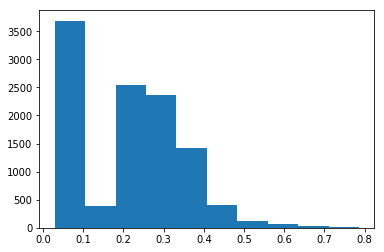

predictions,0,1,All
actuals,,,
0,6885,1891,8776
1,1138,1139,2277
All,8023,3030,11053


In [19]:
plt.hist(predictions)
plt.show()
predictions
pd.crosstab(index=test_data['No-show_Yes'], columns=np.where(predictions > 0.3, 1, 0), rownames=['actuals'], colnames=['predictions'],margins=True)

In summary, of the 11053 patients, we predicted 514 would subscribe and 2277 of them actually did.  We also had 2,013 that were no-shows but we predicted as turning up.  This is less than desirable, but the model can (and should) be tuned to improve this.  


### (Optional) Clean-up

If you are done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)